# Train AE model to have committor as encoder

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import Langevin

### Generate dataset with Boltzmann-Gibbs initial distribution of points. 

In [4]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)

Using device: cuda


In [7]:
pot = MullerBrown()
## Define the radius of the R and P sets
R_radius = 0.1
P_radius = 0.1
pot.set_R_radius(R_radius)
pot.set_P_radius(P_radius)
## Generate 100 penalization points on each boundary of R and P
theta = np.random.uniform(0,np.pi, size=[100])
p_x = np.random.normal(scale=1/beta, size=[100])
p_y = np.random.normal(scale=1/beta, size=[100])

pen_points = np.append(np.append(np.append(pot.minR, np.zeros(2)) + np.array([R_radius * np.cos(theta), R_radius * np.sin(theta), p_x, p_y]).T, np.zeros([100, 1]), axis=1), np.append(np.append(pot.minP, np.zeros(2)) + np.array([P_radius * np.cos(theta), P_radius * np.sin(theta), p_x, p_y]).T, np.ones([100, 1]), axis=1), axis=0)
## Re parameterise the MEP from the various steepest descent paths
MEP = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[0][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[1][-i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[1][-i])
    i += 1
MEP = np.array(MEP)

In [6]:
beta = 0.05 
dt = 0.005
m = np.array([[1., 1.]])
gamma = np.array([[10**0, 10**0]])
unbiased_Langevin_on_MB = Langevin(pot, beta, M=m, gamma=gamma, dt=dt)
x_0 = pot.minP
p_0 =np.random.normal(0, size=pot.minP.shape)
n_steps = 2* 10**5

In [8]:
traj_dict = unbiased_Langevin_on_MB.run(x_0, p_0, n_steps, save_grad=False, save_gauss=True)

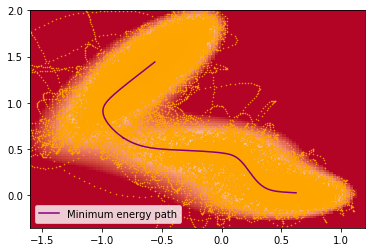

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(traj_dict["x_traj"][:, 0], traj_dict["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

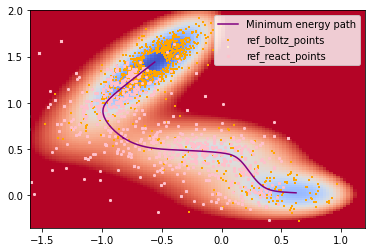

In [10]:
react_points = np.loadtxt('react_trajs_mullerbrown.txt')

ref_react_points = []
ref_boltz_points = [] 
for i in range(1000):
    index = np.random.choice(len(traj_dict["x_traj"]))
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(len(traj_dict["x_traj"]))
    ref_boltz_points.append(traj_dict["x_traj"][index])
    index = np.random.choice(len(react_points))
    while pot.in_P(react_points[index]) or pot.in_R(react_points[index]):
        index = np.random.choice(len(react_points))
    ref_react_points.append(react_points[index])
ref_react_points = np.array(ref_react_points)
ref_boltz_points = np.array(ref_boltz_points)

fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(ref_boltz_points[:, 0], ref_boltz_points[:, 1], marker="+", color="orange", s=5, label="ref_boltz_points")
ax.scatter(ref_react_points[:, 0], ref_react_points[:, 1], marker="x", color="pink", s=5, label="ref_react_points")
ax.legend()


Gather the training dataset (stop the trajectories when R or P is reached (zeros gaussian and constant position to keep constant array shape))


In [11]:
K = 8 * 10**3 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

In [12]:
boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], "single_trajs_mom": [],"single_trajs_gauss": [], "single_trajs_weights": [], 'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    p_traj = []
    gauss_traj = []
    index = np.random.choice(n_steps - N)
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(n_steps - N)
    x_traj.append(traj_dict["x_traj"][index])
    p_traj.append(traj_dict["p_traj"][index])
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            x_traj.append(traj_dict["x_traj"][index + i + 1])
            p_traj.append(traj_dict["p_traj"][index + i + 1])
            gauss_traj.append(traj_dict["gauss_traj"][index + i + 1])
        else:
            x_traj.append(x_end)
            p_traj.append(p_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(traj_dict["x_traj"][index + 1 + i]) or pot.in_R(traj_dict["x_traj"][index + 1 + i]):
            end_in_R_or_P = True
            x_end = traj_dict["x_traj"][index + 1 + i]
            p_end = traj_dict["p_traj"][index + 1 + i]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_mom"].append(p_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])
dataset["single_trajs_mom"] = np.array(dataset["single_trajs_mom"])

Import class for committor AE model and its training

In [18]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOneDecoder

In [14]:
seeds = np.random.randint(10**6, size=10)
seeds 

array([874658, 465839, 591206, 880594, 467876, 986512, 479160, 384565,
       554915, 455805])

Define the model 

In [15]:
del(committor)           # to restart from new model 
del(committor_training)

NameError: name 'committor' is not defined

In [16]:
seed = 36670
set_all_seeds(seed)
committor = CommittorOneDecoder([4, 20, 20, 1], [1, 4], 0, pot, boundary_width=0.0001, handtanh=True)

In [17]:
# Create training object 
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points, eps=1. * 10**(-5))
# Do train test splitt of the dataset 
committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
# Set the optimizer 
committor_training.set_optimizer('Adam', 0.001)
# Set the loss function parameters 
loss_params = {}
loss_params["ito_loss_weight"] = 1.
loss_params["log_ito_loss_weight"] = 0. * 10**(0)
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)
# Set the batch size and a max number of epochs 
batch_size = 10**3
max_epochs = 1000

NameError: name 'TainCommittorOverdampedOneDecoder' is not defined

In [357]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 443 epochs.



Plot committor iso-levels 

In [358]:
np.min(loss_dict["test_ito_loss"])

0.009668912

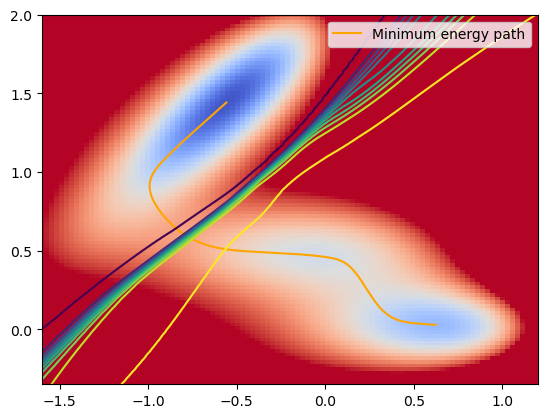

In [359]:
fig = plt.figure()
x = pot.x2d 
#x_and_p = np.append(x, np.zeros_like(x), axis=1)
x_and_p = np.append(x, np.random.normal(scale=1/np.sqrt(beta), size=pot.x2d.shape[1]) * np.ones_like(x), axis=1)
committor_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.contour(pot.x_plot, pot.y_plot, committor_on_grid, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='viridis')
ax.legend()

Plot log of committor isolevels 

/tmp/ipykernel_100296/1489204434.py:14: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_100296/1489204434.py:24: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

<Figure size 640x480 with 0 Axes>

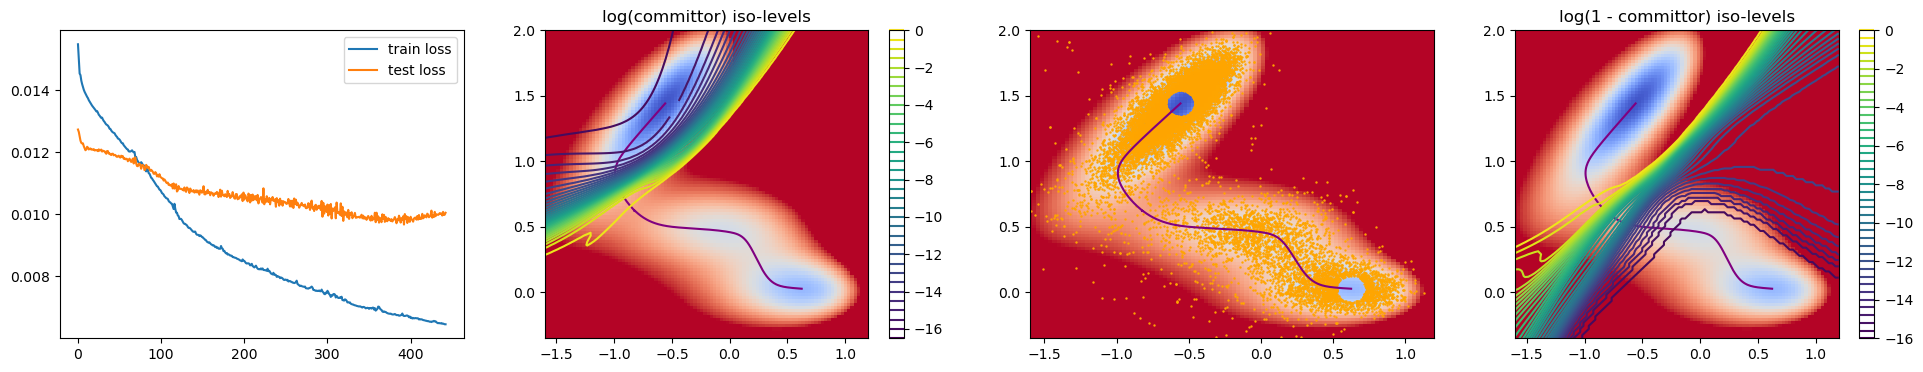

In [371]:
fig = plt.figure()
x = pot.x2d 
#x_and_p = np.append(x, np.zeros_like(x), axis=1)
x_and_p = np.append(x, np.random.normal(scale=1/np.sqrt(beta), size=pot.x2d.shape[1]) * np.ones_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:, 0, 0], committor_training.dataset["single_trajs_pos"][:,0, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

### Generate dataset with Uniform distribution of configurations. 

Generate dataset in which the trajectory is stopped once R or P is reached

In [31]:
K = 8 * 10**2    # number of short trajectories 
N = 100           # time lagg in number of delta t

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], "single_trajs_mom": [],"single_trajs_gauss": [], "single_trajs_weights": [], 'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    p_traj = []
    gauss_traj = []
    x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
    y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
    x_0 = np.array([x_ini,y_ini]).T
    while pot.in_P(x_0) or pot.in_R(x_0):
        x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
        y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
        x_0 = np.array([x_ini,y_ini]).T
    x_traj.append(x_0)
    p_traj.append(np.random.normal(scale=1/beta, size=x_0.shape))
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_Langevin_on_MB.run(x_traj[-1], p_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            p_traj.append(short_traj["p_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            p_traj.append(p_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
            p_end = short_traj["p_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_mom"].append(p_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["single_trajs_mom"] = np.array(dataset["single_trajs_mom"])[:, :, 0, :]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1600,) + inhomogeneous part.

In [ ]:
#del(committor)           # to restart from new model 
#del(committor_training)
seed = 10
set_all_seeds(seed)
committor = CommittorOneDecoder([4, 20, 20, 1], [1, 4], 0, pot, boundary_width=0.0001)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**2
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

batch_size = 10**3
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

Plot approximate committor iso-levels

In [ ]:
fig = plt.figure()
x = pot.x2d 
x_and_p = np.append(x, np.zeros_like(x), axis=1)
committor_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.contour(pot.x_plot, pot.y_plot, committor_on_grid, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='viridis')
ax.legend()

Plot log of committor isolevels

In [ ]:
fig = plt.figure()
x = pot.x2d 
x_and_p = np.append(x, np.zeros_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:, 0, 0], committor_training.dataset["single_trajs_pos"][:,0, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Plot figures to compare to the finite element reference

### Generate dataset distributed according to the distribtion of reactive trajectories. 

Generate dataset in which the trajectory is stopped once R or P is reached

In [18]:
K = 8 * 10**2    # number of short trajectories 
N = 100           # time lagg in number of delta t

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], "single_trajs_mom": [],"single_trajs_gauss": [], "single_trajs_weights": [], 'dt': dt, 'beta': beta}

for k in range(2*K):
    x_traj = []
    p_traj = []
    gauss_traj = []
    index = np.random.choice(len(react_approx_density))
    x_0 = react_approx_density[index:index+1]
    while pot.in_P(x_0) or pot.in_R(x_0):
        index = np.random.choice(len(react_approx_density))
        x_0 = react_approx_density[index:index+1]
    x_traj.append(x_0)
    p_traj.append(np.random.normal(scale=1/beta, size=x_0.shape))
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_Langevin_on_MB.run(x_traj[-1], p_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            p_traj.append(short_traj["p_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            p_traj.append(p_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
            p_end = short_traj["p_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_pos"].append(p_traj)
    #print(np.array(dataset["single_trajs_pos"]).shape)
    dataset["single_trajs_gauss"].append(gauss_traj)
    #print(np.array(dataset["single_trajs_gauss"]).shape)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["single_trajs_mom"] = np.array(dataset["single_trajs_mom"])[:, :, 0, :]

Generate dataset for which trajectories are not stopped when R or P is reached

In [20]:
del(committor)           # to restart from new model 
del(committor_training)
seed = 6248
set_all_seeds(seed)
committor = CommittorOneDecoder([2, 5, 1], [1, 2], 0, pot, boundary_width=0.01)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 1.0 * 10**(8)
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

batch_size = 10**2
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
training ends after 275 epochs.



Plot approximate committor iso-levels

In [ ]:
fig = plt.figure()
x = pot.x2d 
x_and_p = np.append(x, np.zeros_like(x), axis=1)
committor_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.contour(pot.x_plot, pot.y_plot, committor_on_grid, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='viridis')
ax.legend()

Plot log of committor isolevels

In [ ]:
fig = plt.figure()
x = pot.x2d 
x_and_p = np.append(x, np.zeros_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:, 0, 0], committor_training.dataset["single_trajs_pos"][:,0, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")